In [12]:
# %%capture
# import os
# from google.colab import drive

# drive.mount("/content/drive")
# os.chdir("/content/drive/MyDrive/Geophysics/Bosumtwi ML/Code/Bosumtwe")

# ! pip install scikit-learn --upgrade
# # ! pip install pickle --upgrade

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy as cp
import pickle
import os

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from utils import create_folder
from math import floor
from sklearn.base import BaseEstimator

from matplotlib.colors import ListedColormap


In [14]:
# sns.set(font_scale=1.2)
# sns.set_context("paper", rc={"xtick.labelsize": 21, "ytick.labelsize": 21})

In [15]:
def fmt_num(number):
    percentage = number * 100
    formatted_percentage = f"{percentage:.2f}%"
    return formatted_percentage


ml_models_config = {
    "K Nearest Neighbour": {
        "estimator": lambda: KNeighborsClassifier(n_jobs=-1),
        "param_grid": {
            "n_neighbors": [3,4, 5, 6,7],
            "weights": ["uniform", None, 'distance'],
            "algorithm": ["brute", "ball_tree", "kd_tree"],
        },
    },
    "Logistic Regression": {
        "estimator": lambda: LogisticRegression(random_state=0, solver="liblinear"),
        "param_grid": {
            "penalty": ["l2", "l1"],
            "C": [0.1, 1.0, 10 ],
            "max_iter": [100,400,600]
        },
    },
    "Decision Tree": {
        "estimator": lambda: DecisionTreeClassifier(random_state=0),
        "param_grid": {
            "criterion": ["gini", "entropy", "log_loss"],
            "splitter": ["best", "random"],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": [None, "sqrt", "log2", 0.5, 0.8],
        },
    },
    "AdaBoost": {
        "estimator": lambda: AdaBoostClassifier(random_state=0),
        "param_grid": {
            "n_estimators": [100, 200, 300, 50],
            "learning_rate":[0.2, 1, 1.5],
            "algorithm": ["SAMME", "SAMME.R"]
        },
    },
    "Random Forest": {
        "estimator": lambda: RandomForestClassifier(n_jobs=-1, random_state=0),
        "param_grid": {
            "criterion": ["gini", "entropy", "log_loss"],
            "n_estimators": [50, 100, 200, 300],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": [None, "sqrt", "log2", 0.8],
        },
    }
}

label_encoder = None  # just to remove the type error


def plot_confusion_matrix(
    y_true: np.array, y_pred: np.array, sorted_labels: list, plot_title=None, file=None
):
    matrix = confusion_matrix(y_true, y_pred, labels=sorted_labels, normalize="all")

    # Add row and column marginal totals
    row_totals = matrix.sum(axis=1)

    col_totals = matrix.sum(axis=0)
    col_totals = np.append(col_totals, [1])

    # Append the row totals to the matrix
    matrix_with_row_totals = np.append(matrix, row_totals[:, np.newaxis], axis=1)

    # Append the column totals
    matrix_with_totals = np.append(
        matrix_with_row_totals, col_totals[np.newaxis, :], axis=0
    )

    # create masks for coloring
    color_mask = np.zeros_like(matrix_with_totals)
    color_mask[-1, :] = 1
    color_mask[:, -1] = 1

    # create masks for data
    data_mask = np.ones_like(matrix_with_totals)
    data_mask[-1, :] = 0
    data_mask[:, -1] = 0

    plt.figure(figsize=(12.8, 12.8))
    sns.heatmap(
        matrix_with_totals,
        mask=data_mask,
        cbar=False,
        cmap=ListedColormap(["white"]),
        annot=True,
        annot_kws={"fontsize": 19},
        square=True,
        fmt=".2%",
        linewidths=0,
    )
    sns.heatmap(
        matrix_with_totals,
        annot=True,
        annot_kws={"fontsize": 19},
        xticklabels=np.append(
            label_encoder.inverse_transform(sorted_labels), ["Total"]
        ),
        yticklabels=np.append(
            label_encoder.inverse_transform(sorted_labels), ["Total"]
        ),
        cmap="Blues",
        fmt=".2%",
        cbar=False,
        square=True,
        linecolor="black",
        linewidths=0.1,
        mask=color_mask,
    )
    plt.xlabel("Predicted", fontsize=22, labelpad=25)
    plt.ylabel("Actual", fontsize=22, labelpad=25)

    if plot_title is not None:
        plt.title(plot_title)

    if file is not None:
        create_folder("/".join(file.split("/")[:-1]))
        plt.savefig(file, bbox_inches="tight", format="svg")

    plt.show()


def draw_console_line(character, n=70, phrase=None):
    if phrase is None:
        print(character * n)
    else:
        o = floor((n - len(phrase)) / 2)
        print(f"\n{character*o}{phrase}{character*o}")


def display_scores(y_true, y_pred, scores, file_path, plot_title=None):
    accuracy = fmt_num(np.mean(scores["test_accuracy"]))
    recall = fmt_num(np.mean(scores["test_recall"]))
    precision = fmt_num(np.mean(scores["test_precision"]))
    f1 = fmt_num(np.mean(scores["test_f1"]))

    matrix = confusion_matrix(y_true, y_pred, normalize="all")
    overall_acc, producers_acc, users_acc = calculate_producers_and_users_accuracy(
        matrix
    )

    print("Overall Accuracy:", overall_acc)
    for i, (producer_acc, user_acc) in enumerate(zip(producers_acc, users_acc)):
        print(
            f"{label_encoder.inverse_transform([i])[0]} - Producer's Accuracy: {producer_acc:.2f}, User's Accuracy: {user_acc:.2f}"
        )

    print("Accuracy:\t", accuracy)
    print("Recall:\t\t", recall)
    print("Precision:\t", precision)
    print("F1:\t\t", f1)

    plot_confusion_matrix(y_true, y_pred, np.unique(y_true).tolist(), file=file_path, plot_title=plot_title)


def cross_val_predict(estimator, x, y, cv):
    y_preds = []
    y_tests = []

    for train_idx, test_idx in cv.split(x, y):
        x_train, x_test = x[train_idx], x[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        estimator.fit(x_train, y_train)
        y_pred = estimator.predict(x_test)

        y_preds.extend(y_pred)
        y_tests.extend(y_test)

    return y_tests, y_preds


def get_tuned_model(model_name):
    with open(f"./tuned_models/{model_name}.pkl", "rb") as file:
        model = pickle.load(file)

    return model


def plot_predictions(
    estimator: BaseEstimator, cv: RepeatedStratifiedKFold, x: np.ndarray, y: np.ndarray
):
    results = np.empty((0, 10))
    for i_repeat, (train_idx, test_idx) in enumerate(cv.split(x, y)):
        x_train = x[train_idx][:, 1:-1]
        y_train = y[train_idx]
        x_test = x[test_idx][:, 1:-1]
        y_test = y[test_idx]

        depth_n_core = x[test_idx][:, [0, -1]]
        iteration_num = np.full((x_test.shape[0], 1), i_repeat // 10)

        estimator.fit(x_train, y_train)
        prediction = estimator.predict(x_test)

        temp = np.column_stack(
            (
                x_test,
                depth_n_core,
                iteration_num,
                y_test.reshape(-1, 1),
                prediction.reshape(-1, 1),
            )
        )
        results = np.vstack((results, temp))

    return results


def calculate_producers_and_users_accuracy(confusion_matrix):
    num_classes = confusion_matrix.shape[0]

    producers_accuracy = []
    users_accuracy = []
    overall_accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)

    for i in range(num_classes):
        true_positives = confusion_matrix[i, i]
        false_positives = np.sum(confusion_matrix[:, i]) - true_positives
        false_negatives = np.sum(confusion_matrix[i, :]) - true_positives

        producers_accuracy.append(true_positives / (true_positives + false_positives))
        users_accuracy.append(true_positives / (true_positives + false_negatives))

    return overall_accuracy, producers_accuracy, users_accuracy

In [16]:
lb07a = pd.read_csv("data/proper/LB-07A.csv").dropna()
lb08a = pd.read_csv("data/proper/LB-08A.csv").dropna()

lb07a["core"] = "LB-07A"
lb08a["core"] = "LB-08A"

data = pd.concat([lb07a, lb08a])
data.shape

(782, 8)

In [17]:
lith_codes = {
    "polymict lithic breccia": "PLB",
    "monomict lithic breccia": "MLB",
    "suevite": "SUE",
    "shale slate phyllite schist": "SSP",
    "metagreywacke": "MGW",
}

data.lithology.replace(lith_codes, inplace=True)
data.lithology.unique()

array(['PLB', 'SUE', 'MLB', 'SSP', 'MGW'], dtype=object)

In [18]:
x = data.drop(["lithology"], axis=1).values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data.lithology)

gs_x_train, _, gs_y_train, _ = train_test_split(
    x[:, 1:-1], y, random_state=23, stratify=y
)

In [19]:
outer_cv = RepeatedStratifiedKFold(n_splits=10, random_state=3, n_repeats=10)


scoring = {
    "accuracy": make_scorer(accuracy_score),
    "recall": make_scorer(recall_score, average="macro"),
    "precision": make_scorer(precision_score, average="macro"),
    # "roc_auc": make_scorer(roc_auc_score, multi_class="ovo"),  # For multi-class problems
    "f1": make_scorer(f1_score, average="macro")
}

In [20]:
from pprint import pprint

In [21]:
load_saved_model = True

for model_name, config in ml_models_config.items():
    draw_console_line("*", n=120)
    print(model_name.upper())

    if load_saved_model:
        best_estimator = get_tuned_model(model_name)

        pprint(best_estimator.get_params())
        continue
    else:
        estimator = config["estimator"]()
        param_grid = config["param_grid"]

        gs_cv = GridSearchCV(
            estimator, param_grid, cv=outer_cv, scoring="f1", n_jobs=-1
        )
        print(f"Searching for best {model_name} parameters")
        gs_cv.fit(x[:, 1:-1], y)
        best_estimator = gs_cv.best_estimator_

        print("Best parameters:", gs_cv.best_params_)
        with open(f"./tuned_models/{model_name}.pkl", "wb") as file:
            pickle.dump(best_estimator, file)
            print(f"Best estimator saved to ./tuned_models/{model_name}.pkl")

    # get accuracy, recall and precision scores
    scores = cross_validate(
        best_estimator, x[:, 1:-1], y, cv=outer_cv, scoring=scoring, n_jobs=-1
    )

    # get predictions
    y_true, y_pred = cross_val_predict(best_estimator, x[:, 1:-1], y, outer_cv)

    # display results
    draw_console_line("-", phrase=model_name + " Scores")
    plt_file_path = f"./plots/confusion_matrices/{model_name}.svg"
    display_scores(y_true, y_pred, scores, plt_file_path)

************************************************************************************************************************
K NEAREST NEIGHBOUR
{'algorithm': 'brute',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 3,
 'p': 2,
 'weights': None}
************************************************************************************************************************
LOGISTIC REGRESSION
{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}
************************************************************************************************************************
DECISION TREE
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_imp

## Plot predictions of the best estimator


In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = "10"


cols_config = {
    "density": {
        "title": "Density\n[g/cc]",
        "xticks": [2.0, 2.4, 2.8],
    },
    "mag_suscep": {
        "title": "Magnetic Susceptibility\n[log₁₀ x 10⁻⁵ SI]",
        "xticks": [1.0, 1.2, 1.4, 1.6, 1.8],
    },
    "scaler_tmi": {
        "title": "Scaler TMI\n[nT]",
        "xticks": [-2500, 0, 2500],
    },
    "total_gamma": {
        "title": "Total Gamma\n[cps]",
        "xticks": [20, 40, 60, 80],
    },
    "caliper": {
        "title": "Caliper\n[mm]",
        "xticks": [95, 100, 105, 110],
    },
}

core_config = {
    "LB-07A": {"yticks": np.arange(350, 540, 50)},
    "LB-08A": {"yticks": [280, 330, 380, 430, 450]},
}


def plot_well_log(data, y_true, y_pred, core, file_path=None):
    logs = data.columns[1:]
    rows, cols = 1, 7
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 10), sharey=True)
    gs = gridspec.GridSpec(2, 7, height_ratios=[7, 1])

    facies_colors = ["#8080ff", "#bebebe", "#ffff00", "#7cfc00", "#8080ff"]
    facies_colormap = mcolors.ListedColormap(facies_colors)
    facies_labels = [
        "Metagreywacke",
        "Monomict lithic breccia ",
        "Polymict lithic breccia",
        "Shale, slate, phyllite and schist",
        "Suevite",
    ]

    for i in range(cols):
        # plot features
        if i < cols - 2:
            config = cols_config[logs[i]]
            ax = plt.subplot(gs[0, i + 2])

            ax.plot(data[logs[i]], data.depth, lw=1, c="black")
            ax.set_xlabel(f"{config['title']}", fontsize="16")
            ax.set_xticks(config["xticks"])
            ax.xaxis.set_ticks_position("top")
            ax.minorticks_on()
            ax.grid(which="major", linestyle="-", linewidth="0.5", color="lightgrey")
            ax.grid(which="minor", linestyle=":", linewidth="0.5", color="lightgrey")
            ax.set_ylim(max(data.depth), min(data.depth))
            ax.set_yticklabels([])
        # plot actual lithology
        elif i == cols - 1:
            F = np.vstack((y_true, y_true)).T
            lith_ax = plt.subplot(gs[0, 0])
            lith_ax.imshow(
                F,
                aspect="auto",
                extent=[0, 1, max(data.depth), min(data.depth)],
                cmap=facies_colormap,
            )
            lith_ax.set_xlabel("Actual Lithology", fontsize="16")
            lith_ax.set_xticks([])

            legend_patches = [
                plt.Line2D(
                    [0],
                    [0],
                    marker="s",
                    color="w",
                    ls="",
                    label=label,
                    markerfacecolor=color,
                )
                for color, label in zip(facies_colors, facies_labels)
            ]
        # plot predicted lithology
        elif i == cols - 2:
            F = np.vstack((y_pred, y_pred)).T
            pred_ax = plt.subplot(gs[0, 1])
            pred_ax.imshow(
                F,
                aspect="auto",
                extent=[0, 1, max(data.depth), min(data.depth)],
                cmap=facies_colormap,
            )
            pred_ax.set_xlabel("Predicted Lithology", fontsize="16")
            pred_ax.set_xticks([])
            pred_ax.set_yticklabels([])

            legend_patches = [
                plt.Line2D(
                    [0],
                    [0],
                    marker="s",
                    color="w",
                    ls="",
                    label=label,
                    markerfacecolor=color,
                )
                for color, label in zip(facies_colors, facies_labels)
            ]
    for i in range(cols):
        ax = plt.subplot(gs[0, i])
        ax.set_yticks(core_config[core]["yticks"])
        ax.tick_params(axis="both", labelsize="15")

    legend_ax = plt.subplot(gs[1, :])
    legend_ax.legend(
        handles=legend_patches,
        loc="lower center",
        prop={"size": 16},
        ncols=5,
        title="Legend",
        markerscale=2.2,
        frameon=False,
        title_fontproperties={"size": 18, "weight": "bold"},
        handletextpad=0.4,
    )
    legend_ax.set_axis_off()

    plt.subplots_adjust(wspace=2)
    plt.tight_layout()

    if file_path is not None:
        create_folder("/".join(file_path.split("/")[:-1]))
        plt.savefig(file_path, bbox_inches="tight", format="svg")

    plt.show()

In [10]:
model_name = "Random Forest"
estimator = get_tuned_model(model_name)
results = plot_predictions(estimator, outer_cv, x, y)
results_df = pd.DataFrame(
    results,
    columns=[
        "density",
        "mag_suscep",
        "scaler_tmi",
        "total_gamma",
        "caliper",
        "depth",
        "core",
        "rskcv_iter",
        "y_test",
        "y_pred",
    ],
)


results_df.y_test = results_df.y_test.astype(int)
results_df.y_pred = results_df.y_pred.astype(int)
results_df

,density,mag_suscep,scaler_tmi,total_gamma,caliper,depth,core,rskcv_iter,y_test,y_pred
0,2.186,1.246,-1692.311,49.057,100.394,344.0,LB-07A,0,2,2
1,2.184,1.264,-1627.125,49.763,100.564,344.5,LB-07A,0,2,2
2,2.182,1.348,-1287.053,52.72,100.161,351.5,LB-07A,0,2,2
3,2.255,1.394,-1333.393,48.566,101.457,356.0,LB-07A,0,2,2
4,2.357,1.351,-1094.714,43.904,102.754,358.0,LB-07A,0,2,2
...,...,...,...,...,...,...,...,...,...,...
7815,2.466,1.329,121.457,49.252,99.345,400.5,LB-08A,9,0,0
7816,2.662,1.404,454.986,47.273,99.428,407.0,LB-08A,9,0,0
7817,2.637,1.456,475.406,47.824,99.459,407.5,LB-08A,9,0,0
7818,2.635,1.384,206.541,46.021,100.828,446.0,LB-08A,9,0,0


In [12]:
best_iteration_idx = (
    results_df.groupby("rskcv_iter")
    .apply(lambda x: f1_score(x.y_test, x.y_pred, average="macro"))
    .idxmax()
)
best_iteration_df = results_df[results_df.rskcv_iter == best_iteration_idx].copy(
    deep=True
)


In [13]:
grouped = best_iteration_df.groupby("core")
grouped_dataframes = {group_name: group_df for group_name, group_df in grouped}

lb07a = grouped_dataframes["LB-07A"]
lb08a = grouped_dataframes["LB-08A"]

selected_cols = [
    "depth",
    "density",
    "mag_suscep",
    "scaler_tmi",
    "total_gamma",
    "caliper",
    "y_test",
    "y_pred",
]
lb07a = lb07a[selected_cols]
lb08a = lb08a[selected_cols]

lb07a = lb07a.sort_values(by="depth")
lb08a = lb08a.sort_values(by="depth")

C:\Users\steve\AppData\Local\Temp\ipykernel_15668\931387579.py:58: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[0, i + 2])
C:\Users\steve\AppData\Local\Temp\ipykernel_15668\931387579.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pred_ax = plt.subplot(gs[0, 1])
C:\Users\steve\AppData\Local\Temp\ipykernel_15668\931387579.py:72: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  lith_ax = plt.subplot(gs[0, 0])


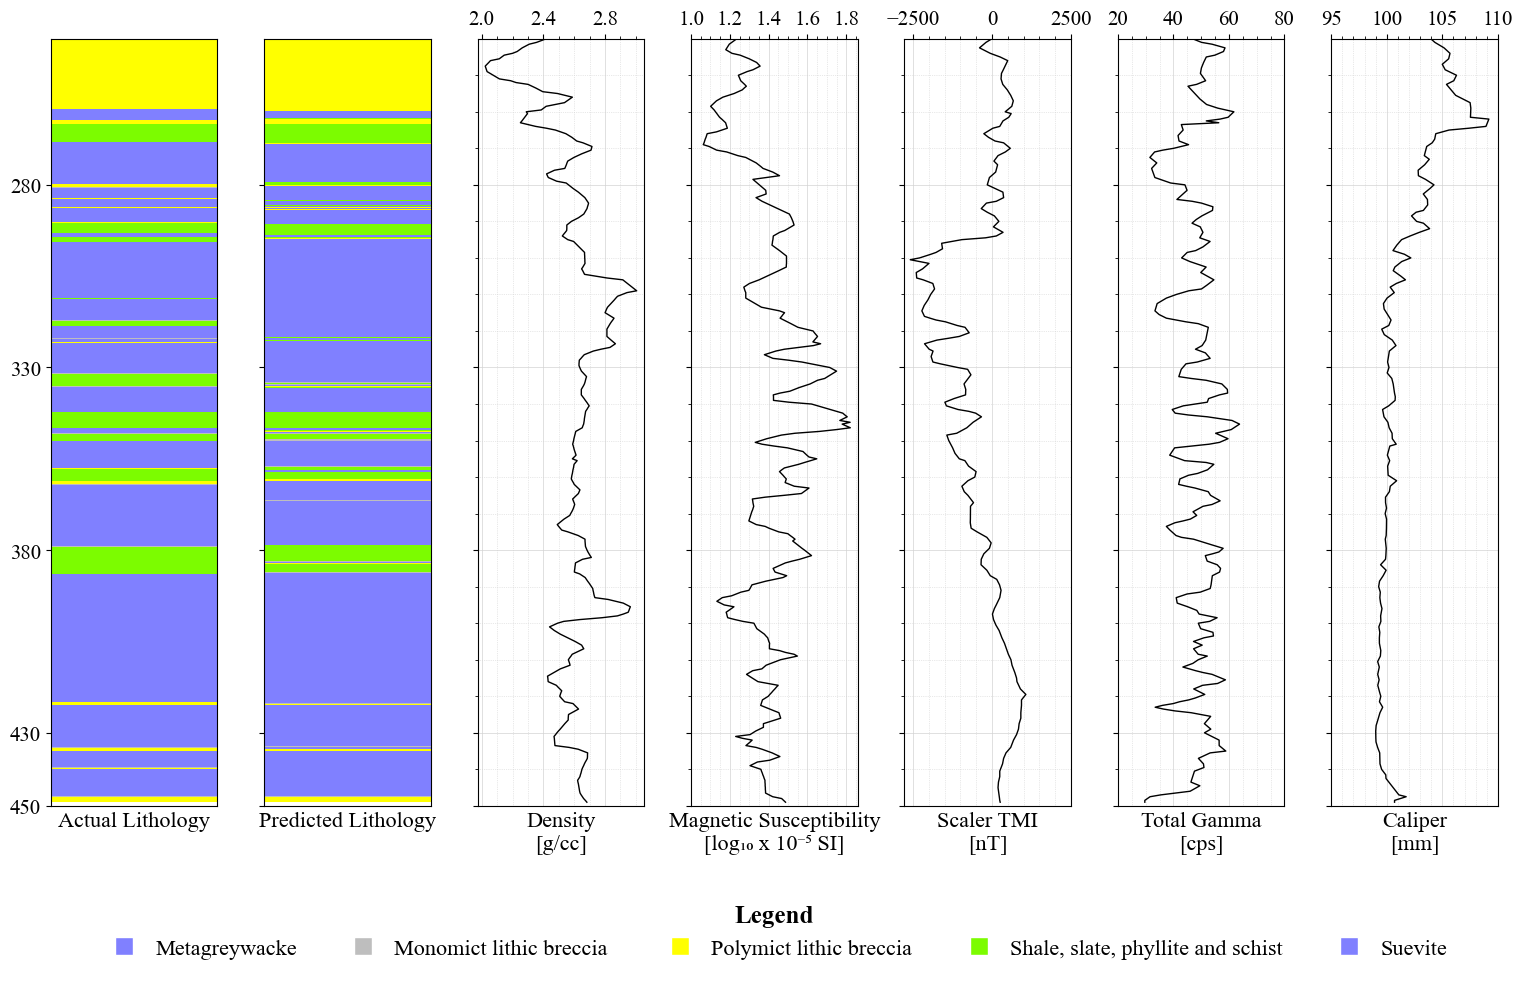

In [14]:
file_path = f"./plots/well_log_plots/Predicted LB-08A.svg"
plot_well_log(lb08a, lb08a.y_test, lb08a.y_pred, "LB-08A", file_path)

C:\Users\steve\AppData\Local\Temp\ipykernel_15668\931387579.py:58: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[0, i + 2])
C:\Users\steve\AppData\Local\Temp\ipykernel_15668\931387579.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pred_ax = plt.subplot(gs[0, 1])
C:\Users\steve\AppData\Local\Temp\ipykernel_15668\931387579.py:72: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  lith_ax = plt.subplot(gs[0, 0])


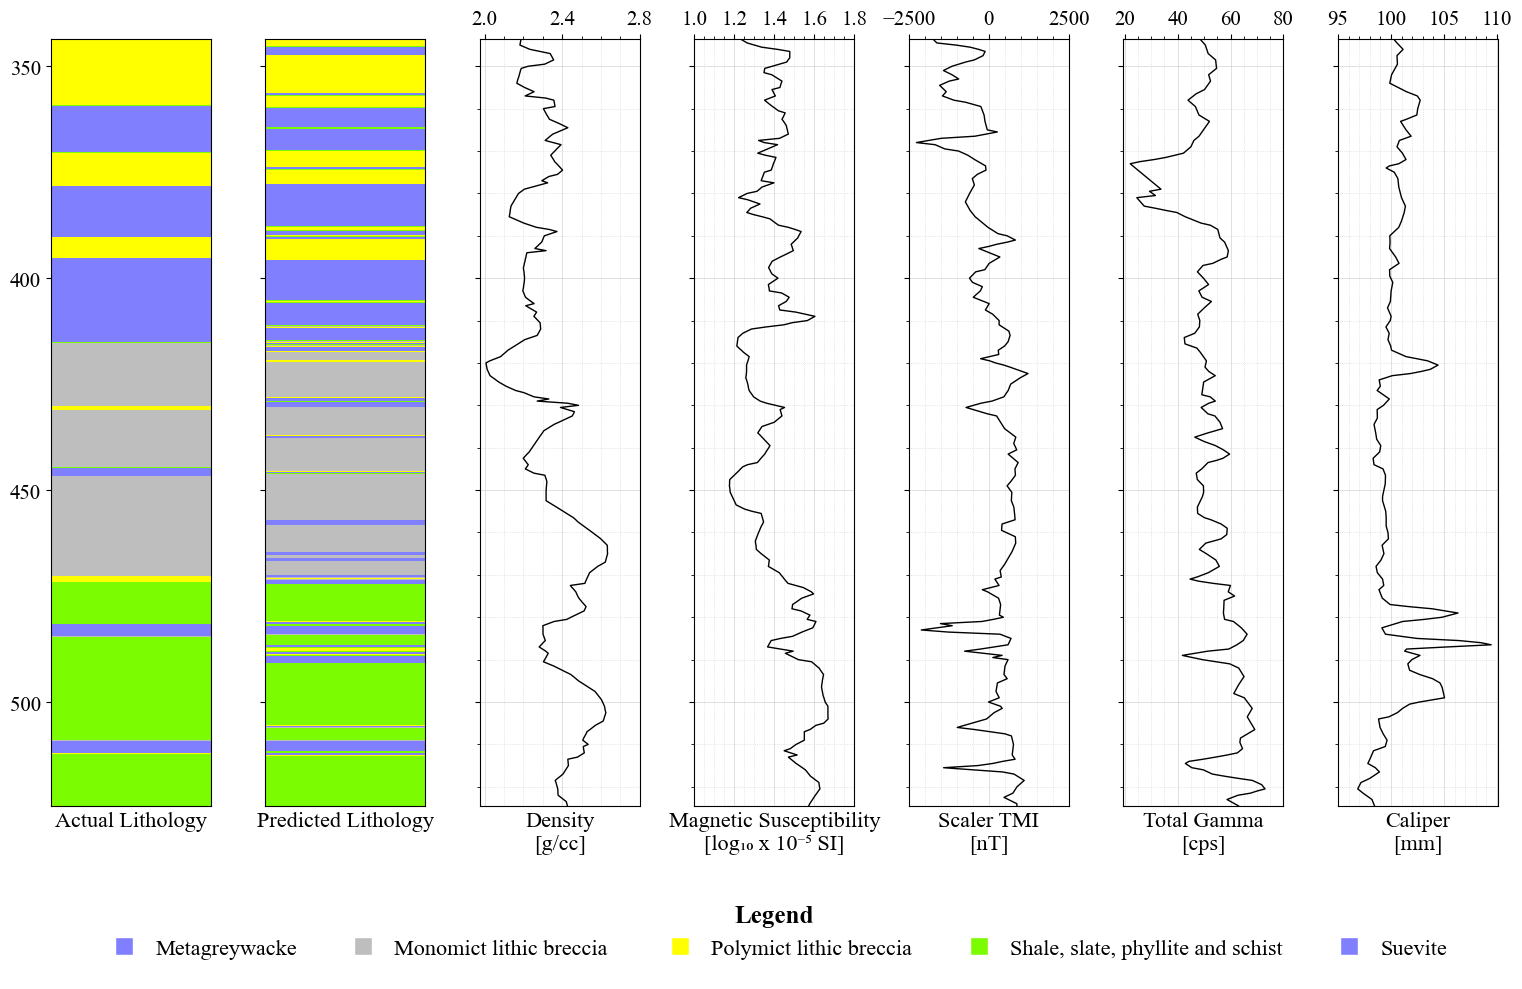

In [15]:
file_path = f"./plots/well_log_plots/Predicted LB-07A.svg"
plot_well_log(lb07a, lb07a.y_test, lb07a.y_pred, "LB-07A", file_path)